This notebook will guide you through the process of creating and running the CHSH experiment much like we would do in our lab. You will find some hints on how to build the circuit and measure it. Feel free to challenge yourself and write the experiment without looking at the hints. However, know that the answers are provided below the exercises and the code solutions can be found in the `solutions` folder, so you can access them at anytime.

Also do not hesitate to ask us any questions that might arise during the process, we are friendly and do not bite! ^_^

## CHSH Experiment

The CHSH (Clauser, Horne, Shimony, Holt) experiment is often used to prove [Bell's theorem](https://en.wikipedia.org/wiki/Bell%27s_theorem). Since it relies on maximum entangled states, it is a pretty standard experiment to prove "quantumness" of a qpu.

For this experiment, we need to prepare our qubits in one of four Bell basis:

$$|\Phi^+ \rangle = \frac{1}{\sqrt{2}} (|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B )$$
$$|\Phi^- \rangle = \frac{1}{\sqrt{2}} (|0\rangle_A \otimes |0\rangle_B - |1\rangle_A \otimes |1\rangle_B )$$
$$|\Psi^+ \rangle = \frac{1}{\sqrt{2}} (|0\rangle_A \otimes |1\rangle_B + |1\rangle_A \otimes |0\rangle_B )$$
$$|\Psi^- \rangle = \frac{1}{\sqrt{2}} (|0\rangle_A \otimes |1\rangle_B - |1\rangle_A \otimes |0\rangle_B )$$

Where our qubits are $A$ and $B$. After that, we use a _witness_ to measure the qubit in several of given basis (more on that below) .This is equivalent to rotating the qubit by some angle $\theta$ and then measuring in the usual $\sigma_z$ direction where our computational states are typically
$$|0\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix},   |1\rangle = \begin{pmatrix} 0 \\ 1 \end{pmatrix}$$

With these rotations, we can obtain 4 different measurements for a given qubit pair (since we cannot copy quantum states this means that we have to perform the experiment 4 times to obtain these 4 measurements)  and calculate the quantity (more on these rotations below) $$S =E(a,b) - E(a,b') + E(a',b) + E(a',b')$$ 

The first step is to import all necessary modules and prepare the remote api

In [1]:
from itertools import product
import logging
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from qibo.gates import M, RY, CZ, I, H
from qibo.models import Circuit
from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

api = API(ConnectionConfiguration(username="ACMQili", api_key="2024Qilimanjaro"))

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.ERROR)

### Experiment parameters

The qpu used for this experiment has a "star" like topology:

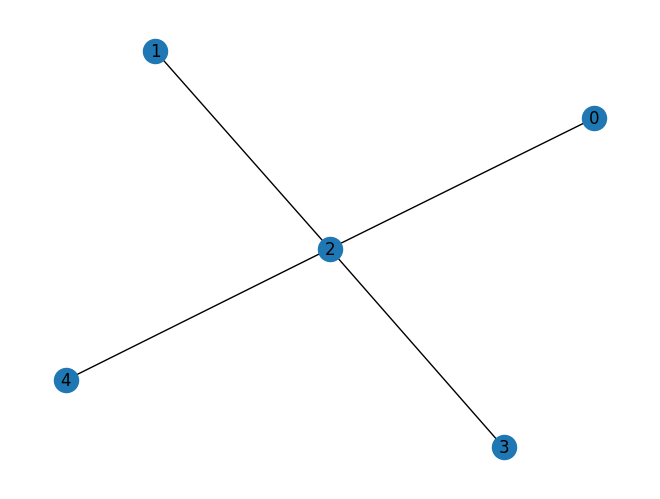

Where each qubit is labeled with a number (qubit index). Note 2 important details:
- While you can perform swap gates to do "virtual" 2 qubit gates between not connected qubits, the only real (and therefore more reliable) 2 qubit gates are between any qubit and qubit 2
- Each qubit is addressed by its index. This means that to manipulate qubit 3, you need to create an algorithmic circuit with 4 qubits and address that index, e.g. with qibo:
```python
    from qibo.models import Circuit
    from qibo.gates import X, M
    c = Circuit(4)
    c.add([X(3), M(3))]
```

Now we define circuit constants:

In [2]:
CONTROL_QUBIT = 0
TARGET_QUBIT = 2
THETA_VALUES = np.linspace(-np.pi, np.pi, num=20)
BELL_STATE = "phi_plus" # phi_plus, phi_minus, psi_plus, psi_minus
NUM_SHOTS=1000

job_id = 13985
LOAD_RESULTS = True
mfidelity_qc = 0.882 # measurement fidelity control qubit
mfidelity_qt = 0.875 # measurement fidelity target qubit

# Circuit definition

Define the circuit for the state $\phi^+$ (_phi plus_). Given that the native gates for our chip are 1qubit rotations and CZ gates, what would be the minimal circuit (with RY and CZ gates) that we would need to construct this state? Try to construct the circuit.
<details>
    <summary>Click here to see the answer!</summary>
    
    You need the following gates: RY(0,-π/2), RY(2,π/2), CZ(0,2), RY(1,-π/2)
    
</details>

Note that the CZ gate is symmetric (see how it's operator matrix looks like) so $CZ(0,2) = CZ(2,0)$ 

You also need to add the _decoder_ part. This is the part of the circuit that adds a continuous rotation (through which we will iterate in the experiment) to the bell pair's control qubit and also rotates the pair to another basis. Since we want to measure in all combinations of the basis for $\sigma_z, \sigma_x$, you need to add (4) pairs of gate rotations `[Gate(control_qubit), Gate(target_qubit)]` (one of the gates should move one of the qubits to either the Z or X basis)
<details>
    <summary>What should these gates be?</summary>
    
    By definition our qubits are measured in the Z basis, therefore we do not need to do anything to move a qubit to this basis. The gate for this (doing nothing) is the idendity I
    In order to move to the X basis, we need to apply a Hadamard (H) gate. You can check this by applying a H gate to a qubit in its ground state and check that H|0> = |0> + |1> = |+> which is an eigenstate of the X basis.
    Therefore the sets of gates that you should apply are RY(control_qubit) - [II,IH,HI,HH]
    
</details>

In [3]:
def get_chsh_circuits(control_qubit: int, target_qubit: int, theta: float):
    """Gets the circuits for the chsh experiment for a given angle of rotation theta.

    Args:
        control_qubit (int): control qubit 
        target_qubit (int): target qubit
        theta (float): angle of roation for the witness/decoder

    Returns:
        list[Circuit]: Set of 4 circuits corresponding to each of the basis in which we will measure
    """

    nqubits = max(control_qubit, target_qubit) + 1 # due to the topology of the chip, we have to use 3 qubits

    circuits = []
    for rot_c, rot_t in product([I,H], repeat=2):
        circuit = Circuit(nqubits)
        
        # Prepare bell state
        circuit.add(RY(control_qubit, theta=-np.pi/2))
        circuit.add(RY(target_qubit, theta=np.pi/2))
        circuit.add(CZ(control_qubit, target_qubit))
        circuit.add(RY(target_qubit,theta=-np.pi/2))
        
        # Decoder
        circuit.add(RY(control_qubit, theta=theta))
        circuit.add(rot_c(control_qubit))
        circuit.add(rot_t(target_qubit))
        circuit.add(M(control_qubit, target_qubit))
        
        circuits.append(circuit)
    return circuits

### Witness

We call the quantity $S =E(a,b) - E(a,b') + E(a',b) + E(a',b')$ a _witness_. For each bell state, there are 2 possible witnesses and we will calculate both of them for the $\phi^+$ state. Each of the four "E(a,b)" (prime/not prime) terms corresponds to a measurement in one of the four basis we have measured our bell state in. 

<details>
    <summary>Think about which term has to be the negtive one for each of the 2 witnesses for the Phi plus state.</summary>
    
    The minus sign has to go to the terms E(a,b') and E(a',b) for the Phi plus state, which will correspond to the measurments with rotations IH and HI
    
</details>

In the function below `compute_witnesses` we also have the option (if `raw==True`) to apply measurement corrections. This is a common procedure to account for low readout fidelities, usually the weakest link in the quantum computing (fidelity) chain. At the top of this notebook, you can see the values `mfidelity_qc = 0.882` and `mfidelity_qt = 0.875` which correspond to the control and readout qubit's fidelities at the time the experiment was performed.
To correct readout fidelity we can do the following exercise: imagine that we have perfect fidelity: then 100% of the times we prepare a $|0\rangle$ state we will measure 0 and likewise for $|1\rangle$ we will always measure 1. Bad readout fidelity will make us measure a $|0\rangle$ like a 1 and vice versa. You might notice then, that we can construct a _fidelity matrix_ $F$ which transforms perfect states into the actual states we read from the qpu. For this chip in particular, it is reasonable to assume that the fidelities are symmetric i.e. the probability of measuring a 0 like a 1 and a 1 like a 0 are the same. Therefore we have the fidelity matrix acting on a (for example) $|0\rangle$ state like: 
$$
\begin{pmatrix}
    f      & 1-f \\
    1-f     & f \\
\end{pmatrix}
\begin{pmatrix} 1 \\ 0 \end{pmatrix}
=
\begin{pmatrix} f \\ 1-f \end{pmatrix}
$$
For the 2 qubit case, this will be a 4x4 matrix constructed with the fidelities $f_c, f_t$ for the target and control qubit. It follows then that to invert the effect not-perfect readout, we just have to invert this fidelity matrix and apply it to our experiment's measurements.

In [4]:
def compute_witnesses(chsh_results, ea=1, eb=1, raw=False):
    """Calculates the 2 witnesses for a phi plus bell state for all angles of theta measured.

    Args:
        chsh_results (np.ndarray): Array of results, should have shape (len(THETA_VALUES), 4, 4)
        ea (int, optional): Readout fidelity of the first qubit. Defaults to 1.
        eb (int, optional): Readout fidelity of the second qubti. Defaults to 1.
        raw (bool, optional): If True, correct readout fidelities. Defaults to False.

    Returns:
        tuple[np.ndarray,np.ndarray]: Tuple containing 2 arrays corresponding to the 2 possible witnesses
        with values for each theta value.
    """
    len_theta_values = np.shape(chsh_results)[0]
    witness1 = np.zeros(len_theta_values)
    witness2 = np.zeros(len_theta_values)

    fidelity_matrix = np.array([[ea*eb, ea*(1-eb), eb*(1-ea), (1-ea)*(1-eb)],
                    [ea*(1-eb), ea*eb, (1-ea)*(1-eb), eb*(1-ea)],
                    [eb*(1-ea), (1-ea)*(1-eb), ea*eb, ea*(1-eb)],
                    [(1-ea)*(1-eb), ea*(1-eb), eb*(1-ea), ea*eb]])

    signs_witness_1 = np.array([1, 1, -1, 1])
    signs_witness_2 = np.array([1, -1, 1, 1])

    for i, chsh_result in enumerate(chsh_results):
        
        if raw is not True:
            # apply measurement correction
            chsh_result = chsh_result @  np.linalg.inv(fidelity_matrix)

        # calculate expectation values from probabilities
        expectations = chsh_result @ np.array([1, -1, -1, 1])
        # compute witnesses
        witness1[i] = signs_witness_1.T @ expectations
        witness2[i] = signs_witness_2.T @ expectations
    return witness1, witness2

### Build circuits for CHSH and measurement correction

In [5]:
all_circuits = []
for theta in THETA_VALUES:
    circuits_th = get_chsh_circuits(CONTROL_QUBIT, TARGET_QUBIT, theta)
    all_circuits.extend(circuits_th)

### Process real data

In [6]:
# some utility functions to parse the results into the format we want them to be
def get_basis_elements_dict(nqubits):
    # parses results elements to the proper basis format
    basis_elements = {}
    for i, x in enumerate(product(['0', '1'], repeat = nqubits)):
        basis_elements[''.join(x)] = i
    return basis_elements

def process_returned_dataformat(results, nqubits=2):
    """Organises the results returned by qiboconnection into a matrix.

    Args:
        results (list): list of result objects returned by qiboconnection
        nqubits (int, optional): number of qubits. Defaults to 2.

    Returns:
        res (array): matrix of dimensions (len(results), 2**nqubits) containing the
                    probabilities with which each bitstring was found for each circuit.
    """
    res = np.zeros((len(results), 2**nqubits))
    basis_elements_dict = get_basis_elements_dict(nqubits)
    for i, result in enumerate(results):
        for key, val in result["probabilities"].items():
            res[i, basis_elements_dict[key]] = val
    return res

Now we retrieve the results from a past experiment. Due to some unforeseen fluctuations in the chip state, 2 qubit gates are currently not calibrated. To run the experiment through qiboconnection's api, you would just have to run `api.execute` after specifying the `device_id` to select a quantum computer.

In [7]:
if LOAD_RESULTS is False:
  job_id = api.execute(all_circuits, nshots=NUM_SHOTS)[0]
  
## retrieve data
results = api.get_job(job_id).result
data_probabilities = process_returned_dataformat(results, nqubits=2)
## compute witness
w1_raw, w2_raw = compute_witnesses(data_probabilities.reshape(len(THETA_VALUES), 4, 4), raw=True)
w1_corrected, w2_corrected = compute_witnesses(
    data_probabilities.reshape(len(THETA_VALUES), 4, 4), ea=mfidelity_qc, eb=mfidelity_qt, raw=False
)

### Run simulation, get ideal witnesses

Since this experiment is rather small, we can simulate it easily on any run of the mill laptop. We will do that so that we can compare the experimental results with the ideal ones.

In [8]:
circ_list = list(np.copy(all_circuits))
ideal_results_chsh = np.zeros((len(circ_list), 4))
for i, c in enumerate(circ_list):
    ideal_results_chsh[i] += c.execute().probabilities(qubits=[TARGET_QUBIT, CONTROL_QUBIT])

# compute the witnesses for the simulated case
w1_ideal, w2_ideal = compute_witnesses(
    ideal_results_chsh.reshape(len(THETA_VALUES), 4, 4), ea=1, eb=1, raw=False
)

[Qibo 0.2.8|INFO|2024-09-05 23:22:34]: Using numpy backend on /CPU:0
2024-09-05 23:22:34,321 qibo.config  INFO     Using numpy backend on /CPU:0


### Get error bars

In any actual experiment, it is very important to account for noise induced errors and calculate error bars accordingly. We will do this step for you since this is outside the scope of the workshop, but feel free to dive into it if you are interested. For this experiment, since we know that there are many different sources of noise comming from the hardware and we have a discreet number of outcomes from an experiment (00,01,10,00), we model our result's distribution with a multinomial distribution, which we use as a Monte Carlo method to mock many experiments and get the results fluctuations, which we use to get our error bars.

In [9]:
def return_mock_results(data_probabilities, ea=1, eb=1):
    # returns simulated results using distribution from experimental results' probabilities
    mock_results = np.empty(shape=data_probabilities.shape)
    for i, _ in enumerate(mock_results):
        mock_results[i] = (stats.multinomial.rvs(NUM_SHOTS, data_probabilities[i]) / NUM_SHOTS)

    return list((compute_witnesses(mock_results.reshape(-1, 4, 4), ea=mfidelity_qc, eb=mfidelity_qt, raw=False) +
            compute_witnesses(mock_results.reshape(-1, 4, 4), raw=True)))

def get_err_bars(mock_results):
    # calculates the error bars for the experimental values
    data_hist = np.stack(mock_results)
    err_bars = np.empty(len(data_hist.T))
    for i, hist in enumerate(data_hist.T):
        _ , var = stats.norm.fit(hist)
        err_bars[i] =np.sqrt(var)
    return err_bars

# generate n copies of random results
err_w1, err_w2, err_w1_unc, err_w2_unc  = [get_err_bars(mock_results) for mock_results in zip(*[return_mock_results(data_probabilities, ea=mfidelity_qc, eb=mfidelity_qt) for _ in range(1000)])]

### Plot results

Finally we can plot our results and compare them with the simulation! Good job!

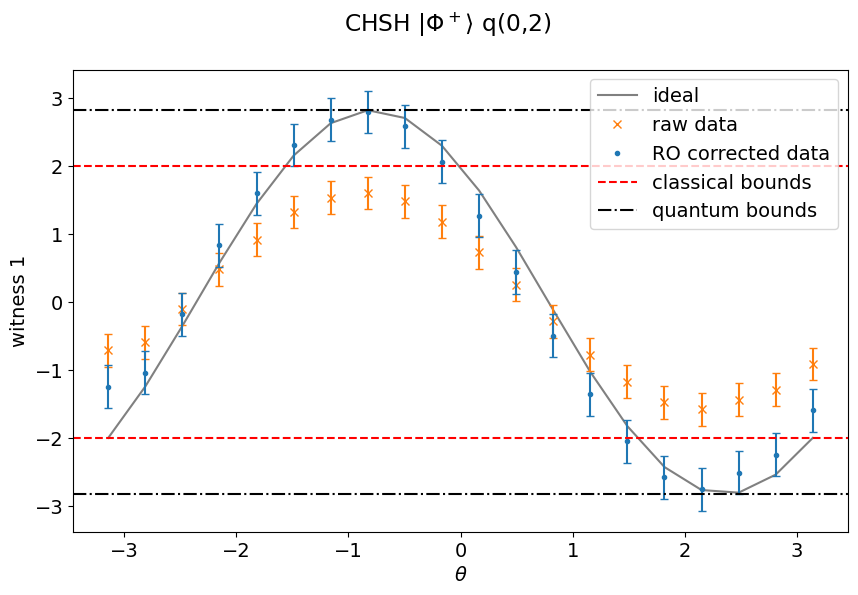

In [10]:
matplotlib.rcParams.update({'font.size': 14})

fname = f"chsh_{CONTROL_QUBIT}_{TARGET_QUBIT}_{BELL_STATE}_nshots{NUM_SHOTS}_jobid{job_id}.png"
savefig = False
bell_names = {"phi_plus": "|$\\Phi^+\\rangle$", "phi_minus": "|$\\Phi^-\\rangle$", "psi_plus": "|$\\Psi^+\\rangle$", "psi_minus": "|$\\Psi^- \\rangle$",}
fig, ax0 = plt.subplots(1, 1, figsize=(10, 6))

# ideal
ax0.plot(THETA_VALUES, w1_ideal, c="grey", label="ideal")
# raw data
ax0.plot(THETA_VALUES, w1_raw, "x", c="C1", label="raw data")
ax0.errorbar(THETA_VALUES, w1_raw, err_w1_unc, capsize=3, c="C1", ls="none")
# corrected data
ax0.plot(THETA_VALUES, w1_corrected, ".", c="C0", label="RO corrected data")
ax0.errorbar(THETA_VALUES, w1_corrected, err_w1, capsize=3, c="C0", ls="none")
ax0.set_ylabel("witness 1")

ax0.axhline(2, color="red", linestyle="--", label="classical bounds")
ax0.axhline(-2, color="red", linestyle="--")
ax0.axhline(2 * np.sqrt(2), color="k", linestyle="-.", label="quantum bounds")
ax0.axhline(-2 * np.sqrt(2), color="k", linestyle="-.")
ax0.set_xlabel("$\\theta$")
ax0.legend()

fig.suptitle(f"CHSH {bell_names[BELL_STATE]} q({CONTROL_QUBIT},{TARGET_QUBIT})")
if savefig:
    fig.savefig(fname, bbox_inches="tight")

** you should get a graph like the following at the end:
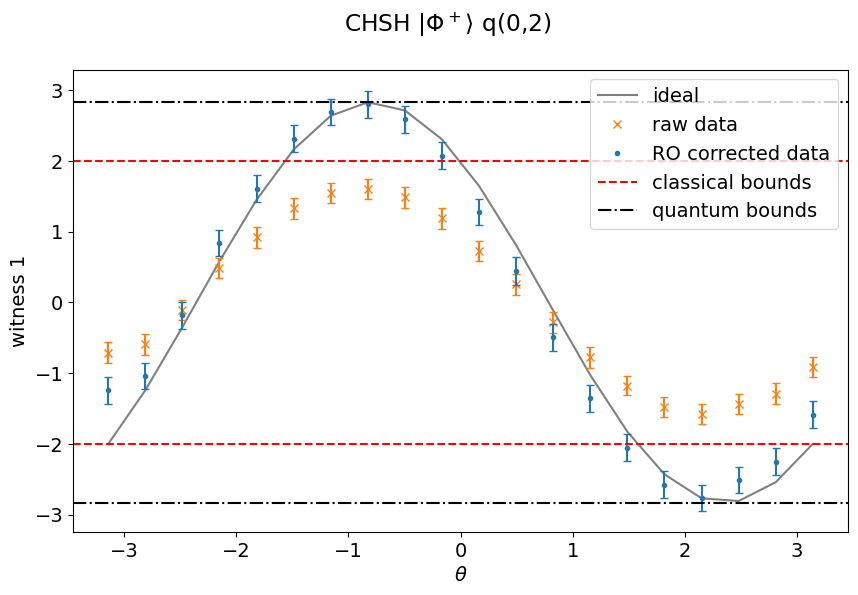